In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**HEART DISEASE DIAGNOSES**

**Introduction:**
 
Heart disease is a range of conditions which affect one's cardiovascular system. The most common condition is coronary artery disease, in which plaque builds up in arteries, narrowing the vessel walls. If the buildup continues, blood will have a hard time flowing through these vessels. This condition can lead to heart attacks or strokes. Several factors influence an individual's likelihood to be diagnosed with this condition, including high blood pressure, high cholesterol, and smoking. Poor diet, excessive drinking, poor fitness, and diabetes are also factors. 
	Using the patient statistics in the UC Irvine University dataset, can we accurately predict the heart disease diagnoses of other patients? We will be using the aforementioned data set that lists 14 factors which influence the likelihood of heart disease, as well as the diagnoses of this patient. The diagnosis column ranges from 1-4, with 1 being no heart disease detected, and 4 being an extreme presence of the disease. Pulling another data set of patient statistics, titled “Heart Disease Prediction”, from this website, we will use a K nearest neighbor calculation, to test if the UC Irvine University dataset can accurately predict the diagnosis in other datasets.

**Research Question:** 

Can we accurately predict if a patient has heart disease based on their age, sex, resting blood pressure, and cholesterol levels? 
i.e. Using the Cleveland Heart Disease dataset, how accurately are we able to predict the presence of heart disease in the Heart Disease Prediction dalevels. 



**Reading The Data**

*Training Data - We will have 303 points as our training data*

In [2]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease

col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- read.table("Data/processed.cleveland.data", 
                         col.names = col_names, sep = ",")


heart_data_anaylsis <- heart_data |> 
    select(age, sex, chol, trestbps, num)
heart_data_anaylsis


number_of_rows <- heart_data_anaylsis |> 
    nrow()
number_of_rows

age,sex,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<dbl>,<int>
63,1,233,145,0
67,1,286,160,2
67,1,229,120,1
⋮,⋮,⋮,⋮,⋮
57,1,131,130,3
57,0,236,130,1
38,1,175,138,0


[1] 303

**Preliminary Exploratory Data Analysis:**

We have summarized the chosen data into two tables. One that contains the averages for the variables of age, chol and trestbps as these values have more variability and another table that contains the variables for sex and the heart disease diagnosis as these two variables have data values that fall into a few distinct levels. 
Tables**

*Below is the table for the mean of the columns that we selected age, chol, and resting blood pressure*

In [3]:
column_mean <- heart_data_anaylsis |> 
    select(age, chol, trestbps)|> 
    map_df(mean)
column_mean

age,chol,trestbps
<dbl>,<dbl>,<dbl>
54.43894,246.6931,131.6898


From the table we can see that all three cholesterol, resting blood pressure, and age all have a significantly different average, therefore, their values would also vary and have a wide range. We would need to scale all three predicators in order for our classificatioin model to be accurate.

*Below is the table of the spread of the different scales of diagnosis of heart disease*


In [4]:
num_counts <- heart_data_anaylsis |> 
    group_by(num) |> 
    count()
num_counts

num,n
<int>,<int>
0,164
1,55
2,36
3,35
4,13


From the table of the number of heart dieseases we can see that the data point is not spread out equally with the majority of the class having a 0 rating of heart disease, therefore, in order to perform classification accurately we would need to scale the data first and have an equal spread of the severity of heart disease. 

*Below is the table of the spread of the different sex in the dataset*

In [5]:
sex_counts <- heart_data_anaylsis |> 
    group_by(sex) |> 
    count() |>
    mutate(sex = as_factor(sex)) 
sex_counts

## 0 == Female
## 1 == Male

sex,n
<fct>,<int>
0,97
1,206


**Initial Visualizations**

*Below are the histogram plots that represents each of the three numerical factors against the diagnosis of heart diseases*

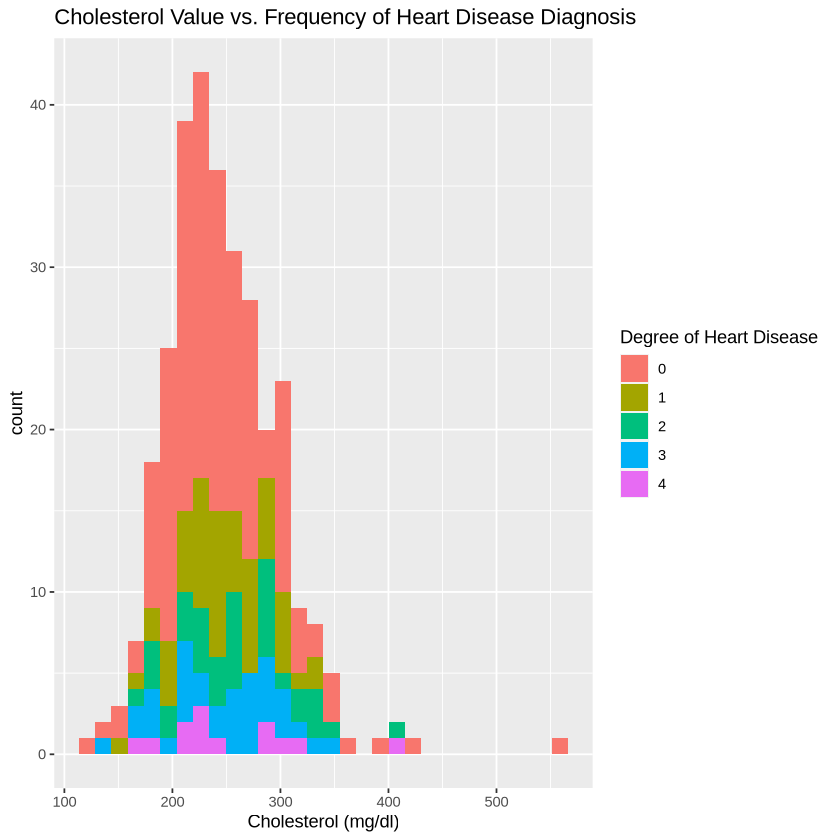

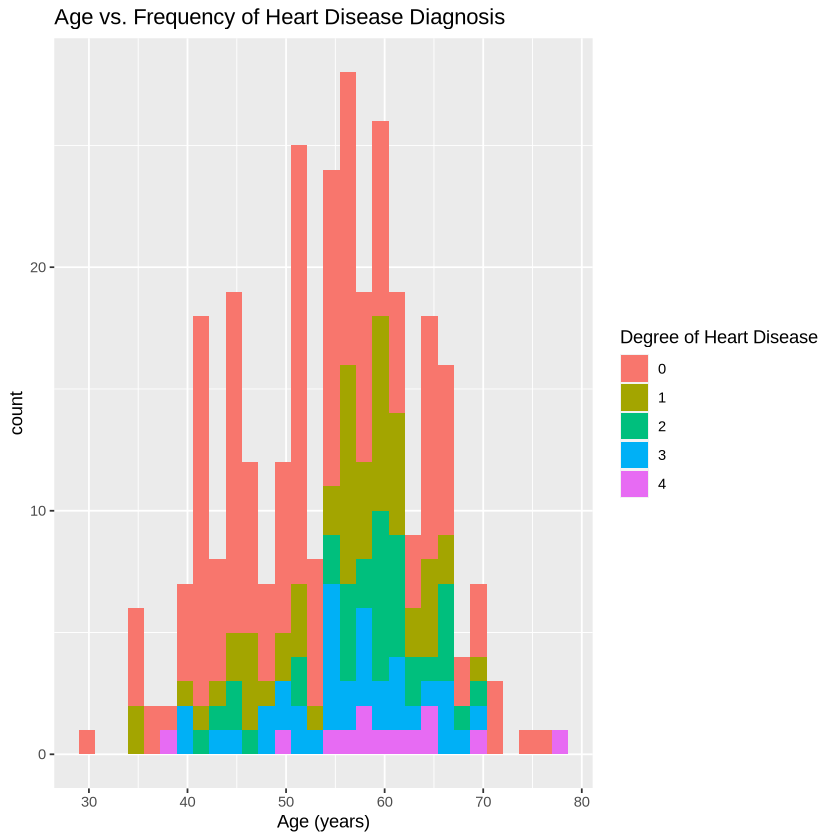

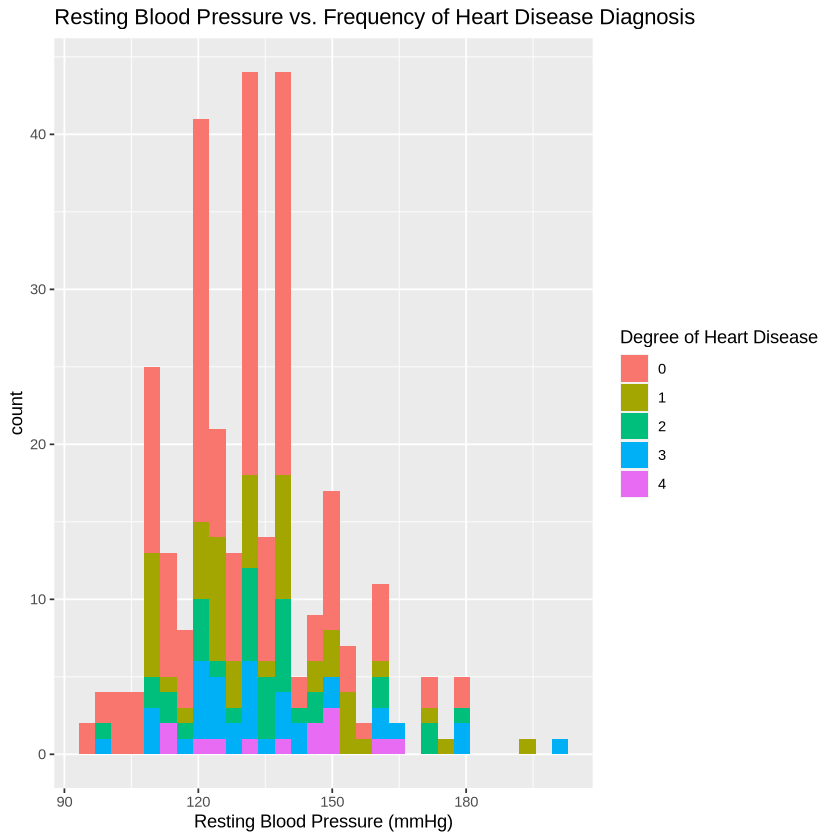

In [6]:
chol_trend_graph <- heart_data_anaylsis |> ggplot(aes(x = chol, fill = factor(num))) + 
    geom_histogram(bins = 30) +
    labs(x = "Cholesterol (mg/dl)", 
         title = "Cholesterol Value vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

age_trend_graph <- heart_data_anaylsis |> 
    ggplot(aes(x = age, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Age (years)", 
         title = "Age vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

trestbps_trend_graph <- heart_data_anaylsis |> 
    ggplot(aes(x = trestbps, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Resting Blood Pressure (mmHg)", 
         title = "Resting Blood Pressure vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

chol_trend_graph
age_trend_graph
trestbps_trend_graph

**Analysis**
Cholrestoral - we can see that although there are a most count of rating 4 heart disease severity around 200 and 300 mg/dl, there are also the most data points there. Therefore, it could be due to other facts. Around 400 chloestoral level, however, we can see that 50% of the patients have rating 4 heart disaese and the other %50 having rating 2 heart disease. Therefore, that could be the most common area of cholestoral for heart disease to appear. 

Age - From the graph we can see that the amount of higher severity heart disease tend to increase as age increases, therefore, we can suspect a positive relationship between the variables. 

Resting Blood Pressure - we can see that the severity of heart disease is spread relatively equal between the intevals of Resting Blood Pressure. The intervals of Resting Bllod Pressure with more data points also have more a variety of the severity. Therefore, it is hard to state a relationship from the histogram right now. 

**Testing Data**

In [7]:
## Data of patients

patient_data <- read_csv("Data/Heart_Disease_Prediction.csv") |> select('Heart Disease', Age, Sex, Cholesterol, BP)

patient_data 

Rows: 270 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (14): index, Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Heart Disease,Age,Sex,Cholesterol,BP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Presence,70,1,322,130
Absence,67,0,564,115
Presence,57,1,261,124
⋮,⋮,⋮,⋮,⋮
Absence,56,0,294,140
Absence,57,1,192,140
Presence,67,1,286,160


**Methods:**

We will clean the data by processing the missing values, scaling and centering the predictor variables and selecting the 4 columns that we will use to predict a diagnosis: age, sex, trestbps and chol, as well as the diagnosis column: num. We will perform 4 K-nearest neighbor calculations using patient data as the new observation to predict if each patient has heart disease. We will compare this prediction to the patient's actual status to calculate the accuracy of the predictions based on the data from the database. 

**Expected Outcomes and Significance:**

We expect to find that this dataset can accurately predict the heart disease diagnosis of patients. This result would be significant since hospitals could compare patient data to this database in order to flag potential sufferers of heart disease. This could lead to a much faster diagnosis which would allow individuals to start management and treatment for the disease earlier. Since the disease would be caught earlier on, its mortality rate would potentially decrease which would save the lives of so many people. Should this data set be accurate in predicting heart disease diagnosis, the question that should be raised is whether such predictive diagnosis can be done for other chronic diseases such as respiratory illnesses given an existing database of patients suffering from such diseases.




**References and Credits:**

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
- Heart Prediction Dataset -  Robert Hoyt MD.

